# Figures 

## SOSE

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt
import json

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
wmt_budget_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/wmt_budget_terms.zarr'))
wmt_budget_terms.load()

/tmp/ipykernel_346/535204962.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  wmt_budget_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/wmt_budget_terms.zarr'))


<xarray.Dataset>
Dimensions:               (time: 438, sigma2_bin: 999)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables: (12/24)
    R1                    (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R1_slt                (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R1_th                 (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R2                    (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    R2_slt                (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    R2_th                 (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_trans_rate      (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_trans_rate_slt  (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_trans_rate_th   (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_adv               (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_vel               (time, sigma2_bin) float64 -1.318e+07 ... -0.0

In [4]:
wmt_budget_terms = wmt_budget_terms.sel(time=slice('2006', '2010'))

## Time mean budgets

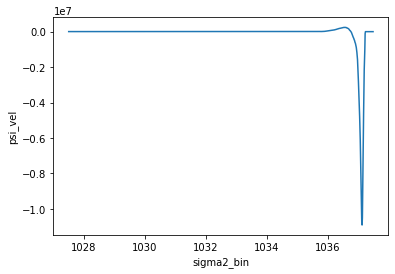

In [5]:
wmt_budget_terms.psi_vel.mean('time').plot()

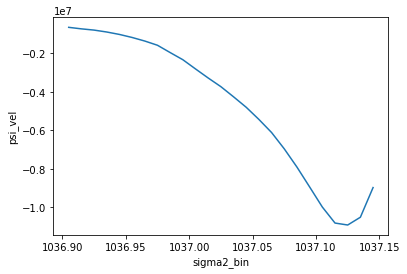

In [6]:
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1036.9, 1037.15)).plot()

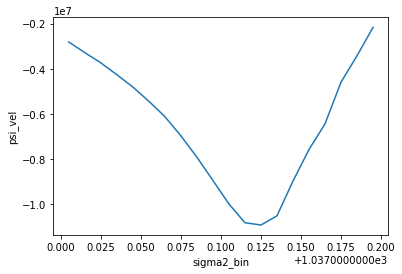

In [7]:
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.0, 1037.2)).plot()

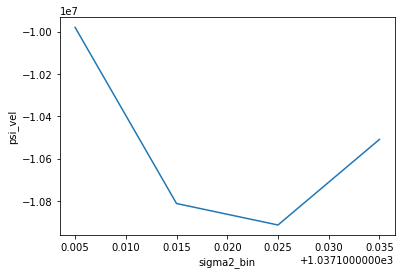

In [8]:
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.1, 1037.14)).plot()

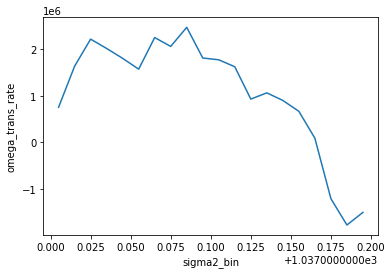

In [9]:
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1037.0, 1037.2)).plot()

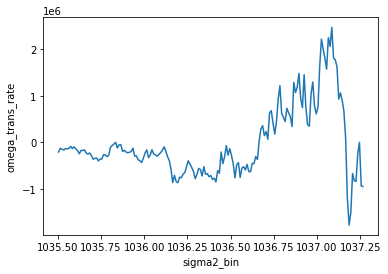

In [10]:
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1035.5, 1037.27)).plot()

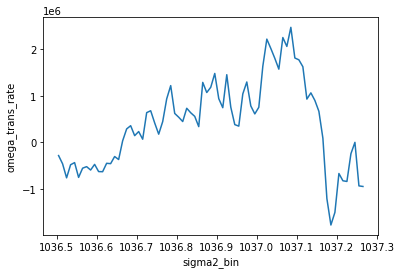

In [11]:
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1036.5, 1037.27)).plot()

### $\frac{\partial V}{\partial t}$

In [12]:
bottom = (wmt_budget_terms.mean('time').isel(sigma2_bin=-1) - 
          wmt_budget_terms.mean('time').sel(sigma2_bin=1037.125, method='nearest'))/1e6
deep = (wmt_budget_terms.mean('time').sel(sigma2_bin=1037.125, method='nearest') - 
        wmt_budget_terms.dVdt.mean('time').isel(sigma2_bin=0))/1e6

In [13]:
bottom.dVdt

<xarray.DataArray 'dVdt' ()>
array(7.85113034)

In [14]:
(wmt_budget_terms.R1.mean('time')[-1] - wmt_budget_terms.R1.mean('time')[0]).values/1e6

0.0

In [15]:
bottom.dVdt + deep.dVdt

<xarray.DataArray 'dVdt' ()>
array(0.)

### E-P-R

### $\Psi$

In [16]:
(wmt_budget_terms.R2.mean('time')[-1] - wmt_budget_terms.R2.mean('time')[0])/1e6

<xarray.DataArray 'R2' ()>
array(0.00366238)

In [17]:
#residual from transport in (deep wm) and out (bottom wm) after considering E-P-2 and R2 term
bottom.psi_vel + deep.psi_vel#+ fw_bot + fw_deep + (wmt_budget_terms.R2.mean('time')[-1] - wmt_budget_terms.R2.mean('time')[0])/1e6

<xarray.DataArray 'psi_vel' ()>
array(0.)

### $\Omega$

In [18]:
bottom.omega_trans_rate + deep.omega_trans_rate

<xarray.DataArray 'omega_trans_rate' ()>
array(0.)

In [19]:
(wmt_budget_terms.omega_trans_rate.mean('time')[-1] - wmt_budget_terms.omega_trans_rate.mean('time')[0])/1e6

<xarray.DataArray 'omega_trans_rate' ()>
array(0.)

In [20]:
#transformation at the boundary between bottom/dm wm
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=1037.125, method='nearest')/1e6

<xarray.DataArray 'omega_trans_rate' ()>
array(0.92951455)
Coordinates:
    sigma2_bin  float64 1.037e+03

In [67]:
#transformation at the avg'd boundary between bottom/dm wm
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1037.0, 1037.2)).mean('sigma2_bin')/1e6

<xarray.DataArray 'omega_trans_rate' ()>
array(1.05798282)

### Bottom $\Omega$s

In [80]:
omegas = list()
bottom_omegas = list()

for var in bottom.data_vars:
    if var == 'omega_total':
        continue 
    elif var == 'omega_total_slt':
        continue
    elif var == 'omega_total_th':
        continue
    elif var.startswith('omega'):
        omegas.append(var)
        bottom_omegas.append(bottom.data_vars[var])

In [81]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th']

In [82]:
bottom_omegas

[<xarray.DataArray 'omega_mix' ()>
 array(0.47423703),
 <xarray.DataArray 'omega_mix_slt' ()>
 array(2.45163801),
 <xarray.DataArray 'omega_mix_th' ()>
 array(-1.97740098),
 <xarray.DataArray 'omega_surf' ()>
 array(-2.58444347),
 <xarray.DataArray 'omega_surf_slt' ()>
 array(-1.71265439),
 <xarray.DataArray 'omega_surf_th' ()>
 array(-0.87178909),
 <xarray.DataArray 'omega_trans_rate' ()>
 array(-0.92951455),
 <xarray.DataArray 'omega_trans_rate_slt' ()>
 array(1.9124347),
 <xarray.DataArray 'omega_trans_rate_th' ()>
 array(-2.84194925)]

In [83]:
len(omegas)

9

In [84]:
len(bottom_omegas)

9

In [85]:
for i in range(9):
    print(bottom_omegas[i].name)

omega_mix
omega_mix_slt
omega_mix_th
omega_surf
omega_surf_slt
omega_surf_th
omega_trans_rate
omega_trans_rate_slt
omega_trans_rate_th


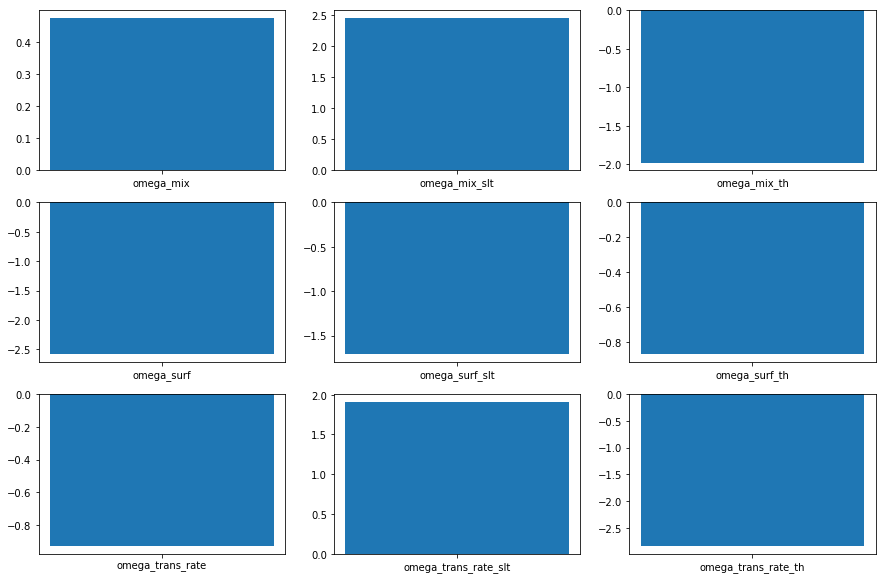

In [86]:
fig, ax = plt.subplots(3,3, figsize=(15,10))
ax = ax.ravel()

for i in range(9):
    ax[i].bar(x=bottom_omegas[i].name, height=bottom_omegas[i].values)

### Boundary $\Omega$s

In [70]:
boundary = wmt_budget_terms.mean('time').sel(sigma2_bin=slice(1037.0, 1037.2)).mean('sigma2_bin')/1e6

In [87]:
omegas = list()
boundary_omegas = list()

for var in boundary.data_vars:
    if var == 'omega_total':
        continue 
    elif var == 'omega_total_slt':
        continue
    elif var == 'omega_total_th':
        continue
    elif var.startswith('omega'):
        omegas.append(var)
        boundary_omegas.append(boundary.data_vars[var])

In [88]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th']

In [89]:
boundary_omegas

[<xarray.DataArray 'omega_mix' ()>
 array(-1.01309589),
 <xarray.DataArray 'omega_mix_slt' ()>
 array(-2.39881256),
 <xarray.DataArray 'omega_mix_th' ()>
 array(1.38571666),
 <xarray.DataArray 'omega_surf' ()>
 array(2.76194063),
 <xarray.DataArray 'omega_surf_slt' ()>
 array(1.59315417),
 <xarray.DataArray 'omega_surf_th' ()>
 array(1.16878646),
 <xarray.DataArray 'omega_trans_rate' ()>
 array(1.05798282),
 <xarray.DataArray 'omega_trans_rate_slt' ()>
 array(-1.49198779),
 <xarray.DataArray 'omega_trans_rate_th' ()>
 array(2.54997061)]

In [90]:
len(omegas)

9

In [91]:
len(boundary_omegas)

9

In [92]:
for i in range(9):
    print(boundary_omegas[i].name)

omega_mix
omega_mix_slt
omega_mix_th
omega_surf
omega_surf_slt
omega_surf_th
omega_trans_rate
omega_trans_rate_slt
omega_trans_rate_th


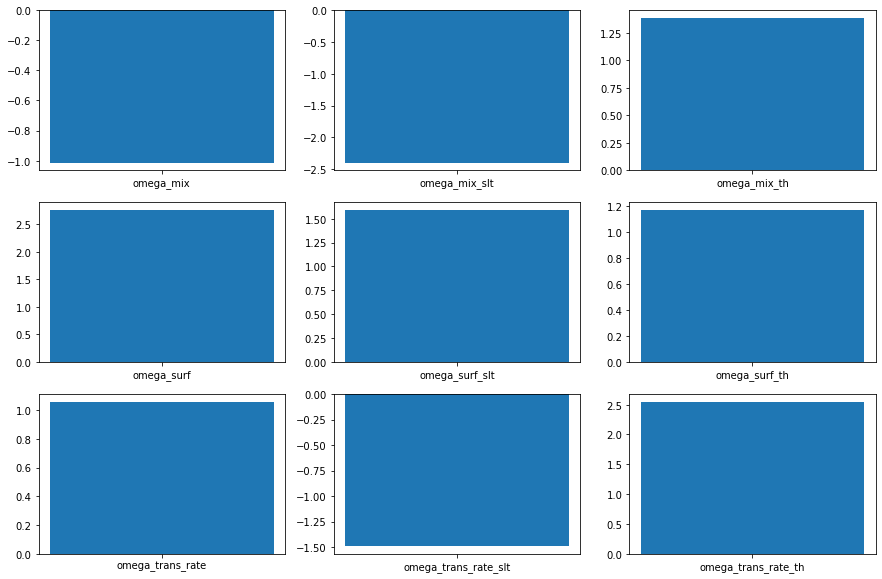

In [95]:
fig, ax = plt.subplots(3,3, figsize=(15,10))
ax = ax.ravel()

for i in range(9):
    ax[i].bar(x=boundary_omegas[i].name, height=boundary_omegas[i].values)

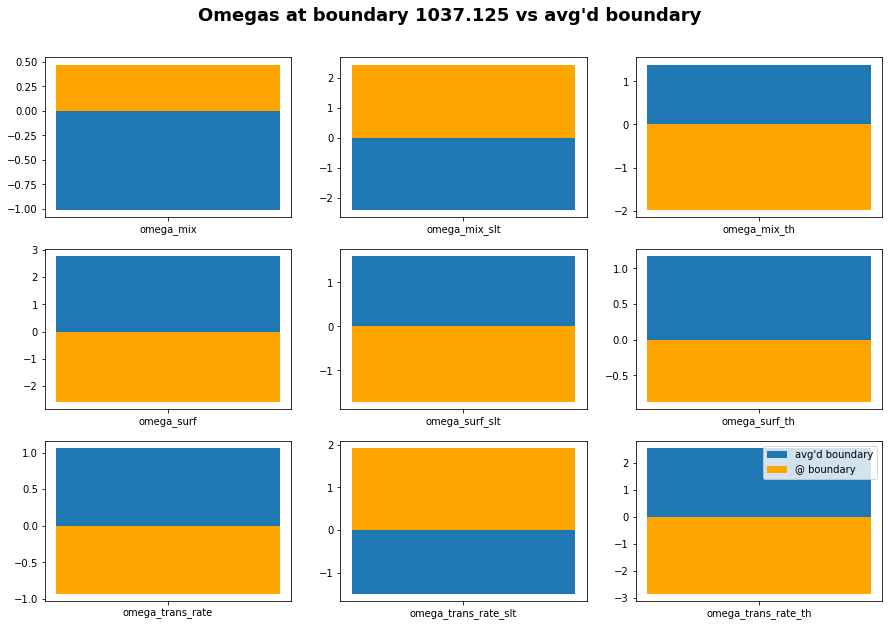

In [106]:
fig, ax = plt.subplots(3,3, figsize=(15,10))
ax = ax.ravel()

for i in range(9):
    ax[i].bar(x=boundary_omegas[i].name, height=boundary_omegas[i].values, label="avg'd boundary")
    ax[i].bar(x=bottom_omegas[i].name, height=bottom_omegas[i].values, color='orange', label='@ boundary')

fig.suptitle("Omegas at boundary 1037.125 vs avg'd boundary", fontweight='bold', fontsize=18, y=0.95)
plt.legend();

### Budget

In [29]:
bottom.dVdt

<xarray.DataArray 'dVdt' ()>
array(7.85113034)

In [30]:
bottom.psi_vel + bottom.omega_trans_rate + bottom.R1 + bottom.R2 + bottom.R3

<xarray.DataArray ()>
array(7.85113034)

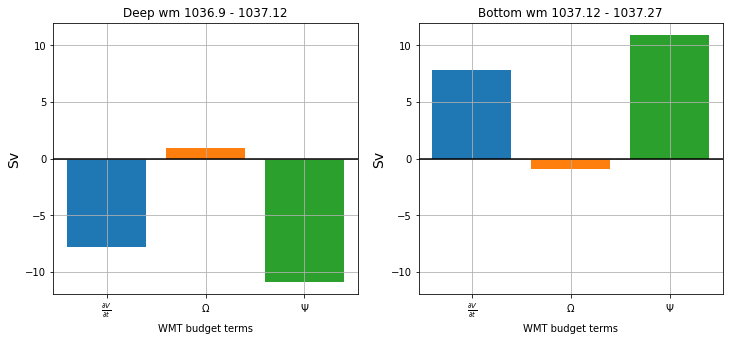

In [31]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt)
ax0.bar(x=r'$\Omega$', height = deep.omega_trans_rate)
ax0.bar(x=r'$\Psi$', height=deep.psi_vel)
ax0.axhline(y=0, color='k')
ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('WMT budget terms')
ax0.grid()
ax0.set_ylim(-12,12)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt)
ax1.bar(x=r'$\Omega$', height = bottom.omega_trans_rate)
ax1.bar(x=r'$\Psi$', height=bottom.psi_vel)
ax1.axhline(y=0, color='k')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms')
ax1.grid()
ax1.set_ylim(-12,12);

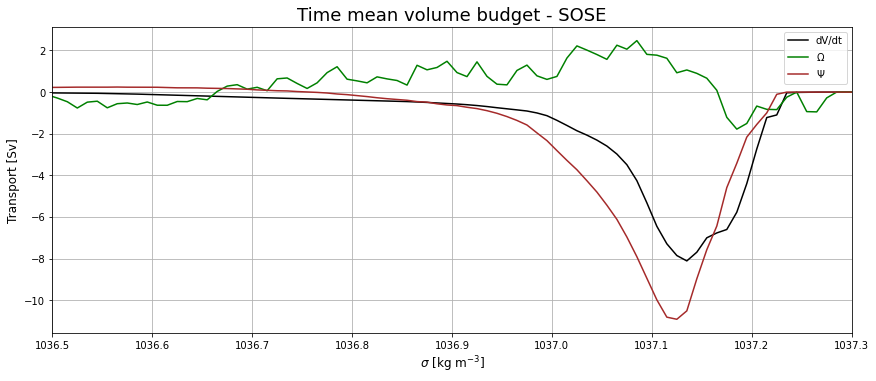

In [32]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
#(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
#(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
#(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
#(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'Time mean volume budget - SOSE', fontsize=18)
plt.xlim(1036.5, 1037.3);

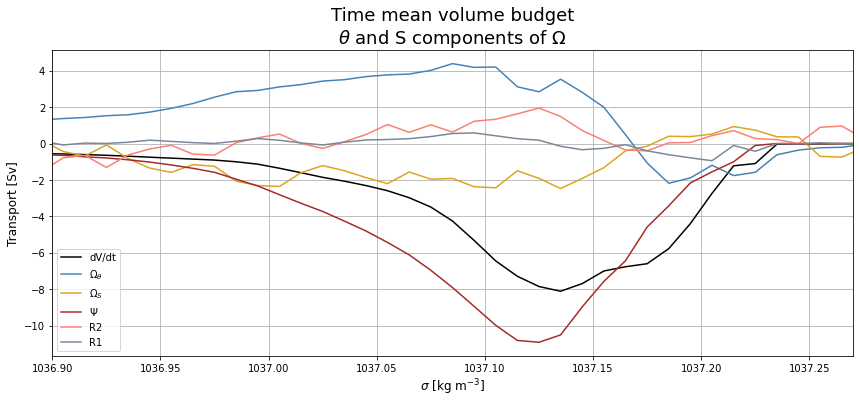

In [33]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue')
(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
#plt.ylim(-12, 12)
plt.xlim(1036.90, 1037.27)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title("Time mean volume budget\n" r'$\theta$ and S components of $\Omega$', fontsize=18);

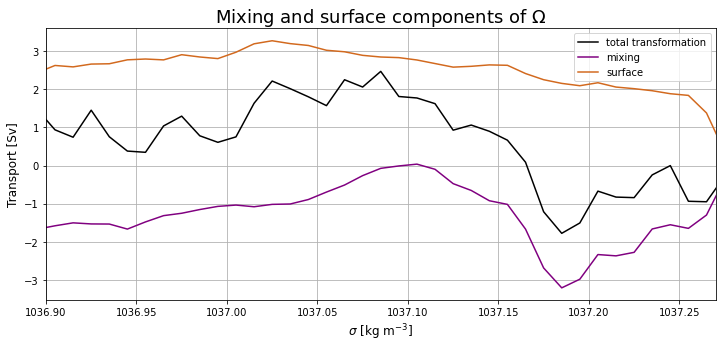

In [34]:
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(figsize=(12,5), label='total transformation', color='k')#, marker='.')
(wmt_budget_terms.omega_mix/1e6).mean(dim='time').plot(label='mixing', color='purple')
(wmt_budget_terms.omega_surf/1e6).mean(dim='time').plot(label='surface', color='chocolate')
plt.legend()
plt.grid()
plt.xlim(1036.90, 1037.27)
#plt.ylim(-6, 6)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'Mixing and surface components of $\Omega$', fontsize=18);

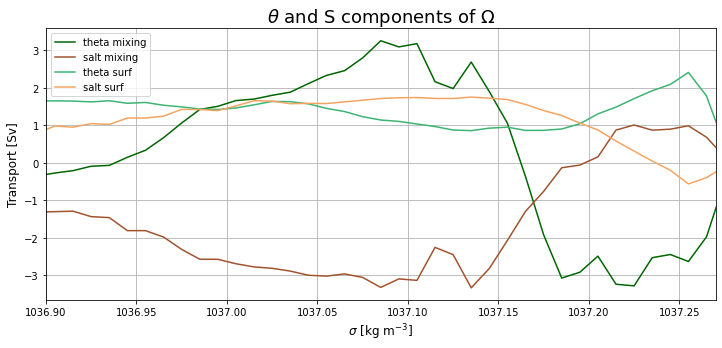

In [35]:
(wmt_budget_terms.omega_mix_th/1e6).mean(dim='time').plot(figsize=(12,5), label='theta mixing', color='darkgreen')
(wmt_budget_terms.omega_mix_slt/1e6).mean(dim='time').plot(label='salt mixing', color='sienna')
(wmt_budget_terms.omega_surf_th/1e6).mean(dim='time').plot(label='theta surf', color='mediumseagreen')
(wmt_budget_terms.omega_surf_slt/1e6).mean(dim='time').plot(label='salt surf', color='sandybrown')
plt.legend()
plt.grid()
plt.xlim(1036.90, 1037.27)
#plt.ylim(-10, 10)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'$\theta$ and S components of $\Omega$', fontsize=18);

## Monthly Climatology

In [36]:
def anom(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    #anom_chunk = anom.chunk({'time':12})
    anom_rolled = anom.rolling(time=73).mean(dim='time') #annual rolling mean to remove seasonal cycle
    return anom_rolled

In [37]:
anom_ds = xr.merge([wmt_budget_terms.dVdt.rename('dVdt'), wmt_budget_terms.R1.rename('R1'), 
                    wmt_budget_terms.psi_vel.rename('psi_vel'), wmt_budget_terms.R2.rename('R2'), 
                    wmt_budget_terms.omega_trans_rate.rename('omega_trans_rate'), 
                    wmt_budget_terms.omega_surf_slt.rename('omega_surf_slt'),
                    wmt_budget_terms.omega_surf_th.rename('omega_surf_th'), 
                    wmt_budget_terms.omega_mix.rename('omega_mix')])


In [38]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [39]:
clim_ds = anom_ds

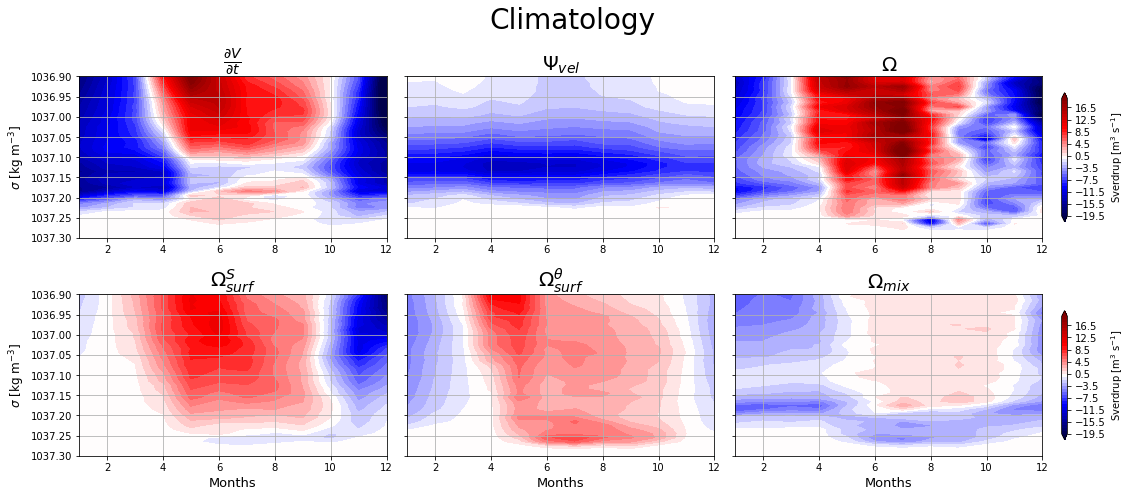

In [40]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-20, 20) + 0.5

dVdt_clim = clim(clim_ds.dVdt) / 1e6
c = ax[0,0].contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin, 
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
ax[0,0].set_ylim(1037.3, 1036.9)
#ax[0,0].set_xlim(xmin='1993')
ax[0,0].grid()

psi_vel_clim = clim(clim_ds.psi_vel) / 1e6
c_psi = ax[0,1].contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20)
#ax[0,1].set_ylim(1037.3, 1035.5)
#ax[0,1].set_xlim(xmin='1993')
ax[0,1].grid()

omega_clim = clim(clim_ds.omega_trans_rate) /1e6
c_omega = ax[0,2].contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega$', fontsize=20)
#ax[0,2].set_ylim(1037.3, 1035.5)
#ax[0,2].set_xlim(xmin='1993')
ax[0,2].grid()

omega_surf_slt_clim = clim(clim_ds.omega_surf_slt)/1e6
c_surf_slt = ax[1,0].contourf(omega_surf_slt_clim.month, 
                                omega_surf_slt_clim.sigma2_bin, 
                                omega_surf_slt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_slt, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[1,0].set_xlabel('Months', fontsize=13)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20)
#ax[1,0].set_ylim(1037.3, 1035.5)
#ax[1,0].set_xlim(xmin='1993')
ax[1,0].grid()

omega_surf_th_clim = clim(clim_ds.omega_surf_th) /1e6
c_surf_th = ax[1,1].contourf(omega_surf_th_clim.month, omega_surf_th_clim.sigma2_bin, 
                        omega_surf_th_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_th, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Months', fontsize=13)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20)
#ax[1,1].set_ylim(1037.3, 1035.5)
#ax[1,1].set_xlim(xmin='1993')
ax[1,1].grid()

omega_mix__clim = clim(clim_ds.omega_mix) / 1e6
c_mix = ax[1,2].contourf(omega_mix__clim.month, omega_mix__clim.sigma2_bin, omega_mix__clim.T, 
                        cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Months', fontsize=13)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20)
#ax[1,2].set_ylim(1037.3, 1035.5)
#ax[1,2].set_xlim(xmin='1993')
ax[1,2].grid()

plt.suptitle('Climatology', fontsize=28)
plt.tight_layout();

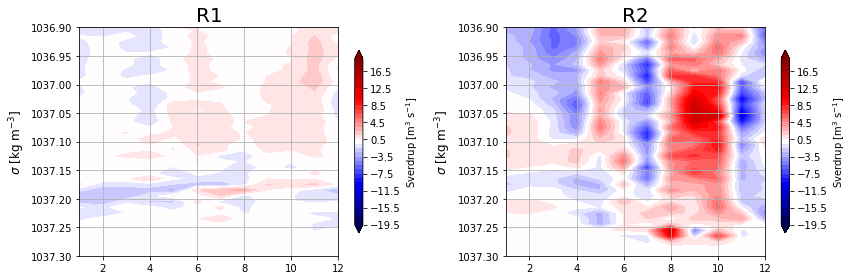

In [41]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,4))

levels = np.arange(-20, 20) + 0.5

R1_clim = clim(clim_ds.R1) / 1e6
c = ax0.contourf(R1_clim.month, 
                   R1_clim.sigma2_bin, 
                   R1_clim.T, cmap='seismic', levels=levels, extend='both')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax0)
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax0.set_title('R1', fontsize=20)
ax0.set_ylim(1037.3, 1036.9)
ax0.grid()

R2_clim = clim(clim_ds.R2) / 1e6
c = ax1.contourf(R2_clim.month, 
                   R2_clim.sigma2_bin, 
                   R2_clim.T, cmap='seismic', levels=levels, extend='both')
plt.colorbar(c, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax1)
ax1.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax1.set_title('R2', fontsize=20)
ax1.set_ylim(1037.3, 1036.9)
ax1.grid()

plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [42]:
dVdt_clim_deep = dVdt_clim.sel(sigma2_bin=1037.125, method='nearest') - dVdt_clim.isel(sigma2_bin=0)
dVdt_clim_deep.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([-15.0980946 , -13.02046204, -12.62156575, -10.55059977,
        -1.47820325,  -1.83107446,  -1.72478996,  -0.96613704,
        -1.98515821,  -6.89967441, -12.36799975, -15.03599545])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [43]:
dVdt_clim_bot = dVdt_clim.isel(sigma2_bin=-1) - dVdt_clim.sel(sigma2_bin=1037.125, method='nearest')
dVdt_clim_bot.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([15.0980946 , 13.02046204, 12.62156575, 10.55059977,  1.47820325,
        1.83107446,  1.72478996,  0.96613704,  1.98515821,  6.89967441,
       12.36799975, 15.03599545])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

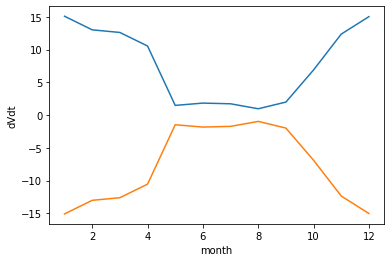

In [44]:
dVdt_clim_bot.plot()
dVdt_clim_deep.plot();

### $\Psi$

In [45]:
psi_clim_deep = psi_vel_clim.sel(sigma2_bin=1037.125, method='nearest') - psi_vel_clim.isel(sigma2_bin=0)
psi_clim_deep.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([-11.3032413 , -11.07173594, -11.53401587, -12.84092372,
       -12.96458237, -12.53804368, -12.53600988, -11.5134708 ,
       -10.41027114,  -8.92763528,  -7.67460655,  -7.78722393])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [46]:
psi_clim_bot = psi_vel_clim.isel(sigma2_bin=-1) - psi_vel_clim.sel(sigma2_bin=1037.125, method='nearest')
psi_clim_bot.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([11.24067461, 11.03335954, 11.55353865, 12.93178935, 12.91147344,
       12.51689038, 12.59154919, 11.4564169 , 10.34869157,  8.83656217,
        7.71951361,  7.90617391])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

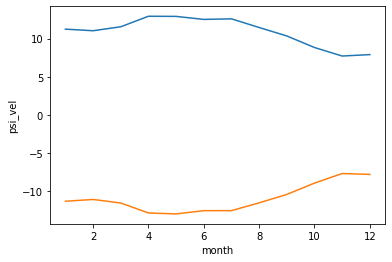

In [47]:
psi_clim_bot.plot()
psi_clim_deep.plot();

### $\Omega$

In [48]:
omega_clim_deep = omega_clim.sel(sigma2_bin=1037.125, method='nearest') - omega_clim.isel(sigma2_bin=0)
omega_clim_deep.load()

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([-5.68723178, -3.47583642, -2.52136703, -0.88037291, 12.30288996,
        6.13122271, 15.44591468,  4.67533315,  0.50352431, -4.7353096 ,
       -2.9873182 , -7.28182744])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [49]:
omega_clim_bot = omega_clim.isel(sigma2_bin=-1) - omega_clim.sel(sigma2_bin=1037.125, method='nearest')
omega_clim_bot.load()

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([  5.68723178,   3.47583642,   2.52136703,   0.88037291,
       -12.30288996,  -6.13122271, -15.44591468,  -4.67533315,
        -0.50352431,   4.7353096 ,   2.9873182 ,   7.28182744])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

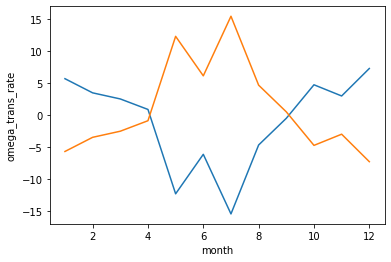

In [50]:
omega_clim_bot.plot()
omega_clim_deep.plot();

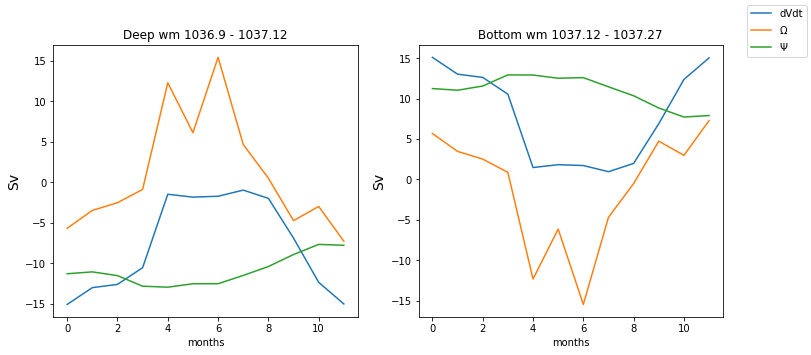

In [51]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(dVdt_clim_deep, label='dVdt')
ax0.plot(omega_clim_deep, label=r'$\Omega$')
ax0.plot(psi_clim_deep, label=r'$\Psi$')

ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('months')

ax1.plot(dVdt_clim_bot)#, label='dVdt')
ax1.plot(omega_clim_bot)#, label=r'$\Omega$')
ax1.plot(psi_clim_bot)#, label=r'$\Psi$')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('months')

fig.legend();

## Anomaly

In [52]:
import warnings
warnings.filterwarnings("ignore")

In [53]:
year_start_index =[0,73, 146, 220, 293]

In [54]:
anom = anom(anom_ds) / 1e6

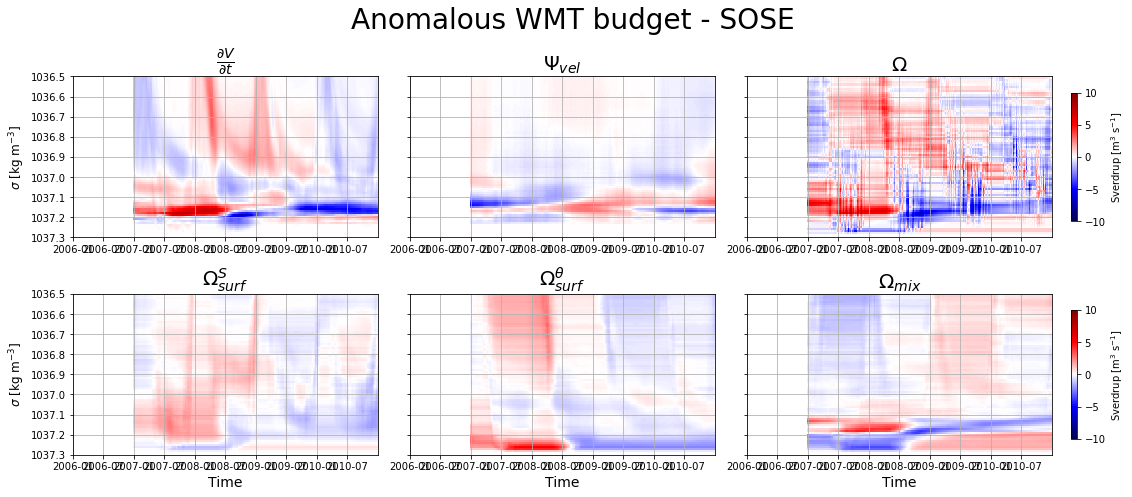

In [55]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

c = ax[0,0].pcolormesh(anom.dVdt.time.values, 
                   anom.dVdt.sigma2_bin, 
                   anom.dVdt.T, vmin=-10, vmax=10, cmap='seismic')
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20)
#ax[0,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,0].set_xticklabels(np.arange(2006, 2011))
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1036.5)


c_psi = ax[0,1].pcolormesh(anom.psi_vel.time.values, anom.psi_vel.sigma2_bin, anom.psi_vel.T,
                        vmin=-10, vmax=10, cmap='seismic')
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20)
#ax[0,1].set_ylim(1037.3, 1036.5)
#ax[0,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,1].set_xticklabels(np.arange(2006, 2011))
ax[0,1].grid()

c_omega = ax[0,2].pcolormesh(anom.omega_trans_rate.time.values, anom.omega_trans_rate.sigma2_bin, anom.omega_trans_rate.T,
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
ax[0,2].set_title(r'$\Omega$', fontsize=20)
#ax[0,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,2].set_xticklabels(np.arange(2006, 2011))
ax[0,2].grid()

c_surf_slt = ax[1,0].pcolormesh(anom.omega_surf_slt.time.values, 
                                anom.omega_surf_slt.sigma2_bin, 
                                anom.omega_surf_slt.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
ax[1,0].set_xlabel('Time', fontsize=14)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20)
#ax[1,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,0].set_xticklabels(np.arange(2006, 2011))
ax[1,0].grid()

c_surf_th = ax[1,1].pcolormesh(anom.omega_surf_th.time.values, anom.omega_surf_th.sigma2_bin, 
                        anom.omega_surf_th.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,1].set_xlabel('Time', fontsize=14)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20)
#ax[1,1].set_ylim(1037.3, 1036.5)
#ax[1,1].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,1].set_xticklabels(np.arange(2006, 2011))
ax[1,1].grid()

c_mix = ax[1,2].pcolormesh(anom.omega_mix.time.values, anom.omega_mix.sigma2_bin, anom.omega_mix.T, 
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
ax[1,2].set_xlabel('Time', fontsize=14)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20)
#ax[1,2].set_xticks(anom.dVdt.time[year_start_index])
#ax[1,2].set_xticklabels(np.arange(2006, 2011))
ax[1,2].grid()

plt.suptitle('Anomalous WMT budget - SOSE', fontsize=28)
plt.tight_layout();

### $\frac{\partial V}{\partial t}$

In [56]:
dVdt_anom_deep = anom.dVdt.sel(sigma2_bin=1037.125, method='nearest') - anom.dVdt.isel(sigma2_bin=0)
dVdt_anom_deep.load()

<xarray.DataArray 'dVdt' (time: 366)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  1.45037565,  1.47193425,  1.50217888,
        1.49062343,  1.46091628,  1.41300431,  1.34926709,  1.28647759,
        1.1922909 ,  1.0963386 ,  1.11718439,  1.11186843,  1.07487771,
        1.09535082,  1.03820843,  1.06310748,  1.04936445,  1.02019867,
        0.98205881,  0.97302983,  0.93728557,  0.95808343,  1.08208539,
        1.24660312,  1.33163301,  1.24735774,  0.73052844,  0.59167664,
...
       -1.72696167, -1.8875281 , -1.93541678, -2.01663257, -1.99988712,
       -2.03027608, -2.14522061, -2.24349667, -2.3314039 , -2.32365002,
       -2.33998109, -2.23690431, -2.23186917, -2.19706536, -2.193259  ,
       -2.0830474 , -2.01293573, -1.9178258 , -1.86805163, -1.91379427,
       -1.95049348, -1.85246796, -1.744054  , -1.75685374, -1.85109956,
       -1.86628338, -1.90954352, -1.91850879, -1.9138124 , -1.98836961,
       -2.06479085, -2.05642687, -2.0577144 , -2.04190568, -2.07856619,
       -2.05006828, -1.97790065, -1.95540484, -2.01956276, -2.03406449,
       -2.07433893, -2.10213275, -2.1307129 , -2.25741452, -2.30471057,
       -2.34395965, -2.32544993, -2.39181302, -2.41172203, -2.37767176,
       -2.46881753, -2.6155635 , -2.67166742, -2.64195118, -2.64923972,
       -2.69840993, -2.74393667, -2.78295164, -2.71177355, -2.63240995,
       -2.50602716, -2.42550626, -2.36120038, -2.34414318, -2.34154527,
       -2.30982457, -2.26497237, -2.25549291, -2.21487566, -2.21051311,
       -2.155061  , -2.09160682, -2.03876088, -2.03523432, -1.83818858,
       -1.81547344, -1.73487701, -1.78262276, -1.71925594, -1.64335079,
       -1.53145826, -1.53533774, -1.62470457, -1.57729954, -1.56944986,
       -1.57095736, -1.60880837, -1.63258639, -1.61056601, -1.5787804 ,
       -1.58785241, -1.60155326, -1.59103682, -1.51192446, -1.42532652,
       -1.3874523 ])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 1 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

In [57]:
dVdt_anom_bot = anom.dVdt.isel(sigma2_bin=-1) - anom.dVdt.sel(sigma2_bin=1037.125, method='nearest')
dVdt_anom_bot.load()

<xarray.DataArray 'dVdt' (time: 366)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -1.45037565, -1.47193425, -1.50217888,
       -1.49062343, -1.46091628, -1.41300431, -1.34926709, -1.28647759,
       -1.1922909 , -1.0963386 , -1.11718439, -1.11186843, -1.07487771,
       -1.09535082, -1.03820843, -1.06310748, -1.04936445, -1.02019867,
       -0.98205881, -0.97302983, -0.93728557, -0.95808343, -1.08208539,
       -1.24660312, -1.33163301, -1.24735774, -0.73052844, -0.59167664,
...
        1.72696167,  1.8875281 ,  1.93541678,  2.01663257,  1.99988712,
        2.03027608,  2.14522061,  2.24349667,  2.3314039 ,  2.32365002,
        2.33998109,  2.23690431,  2.23186917,  2.19706536,  2.193259  ,
        2.0830474 ,  2.01293573,  1.9178258 ,  1.86805163,  1.91379427,
        1.95049348,  1.85246796,  1.744054  ,  1.75685374,  1.85109956,
        1.86628338,  1.90954352,  1.91850879,  1.9138124 ,  1.98836961,
        2.06479085,  2.05642687,  2.0577144 ,  2.04190568,  2.07856619,
        2.05006828,  1.97790065,  1.95540484,  2.01956276,  2.03406449,
        2.07433893,  2.10213275,  2.1307129 ,  2.25741452,  2.30471057,
        2.34395965,  2.32544993,  2.39181302,  2.41172203,  2.37767176,
        2.46881753,  2.6155635 ,  2.67166742,  2.64195118,  2.64923972,
        2.69840993,  2.74393667,  2.78295164,  2.71177355,  2.63240995,
        2.50602716,  2.42550626,  2.36120038,  2.34414318,  2.34154527,
        2.30982457,  2.26497237,  2.25549291,  2.21487566,  2.21051311,
        2.155061  ,  2.09160682,  2.03876088,  2.03523432,  1.83818858,
        1.81547344,  1.73487701,  1.78262276,  1.71925594,  1.64335079,
        1.53145826,  1.53533774,  1.62470457,  1.57729954,  1.56944986,
        1.57095736,  1.60880837,  1.63258639,  1.61056601,  1.5787804 ,
        1.58785241,  1.60155326,  1.59103682,  1.51192446,  1.42532652,
        1.3874523 ])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 1 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

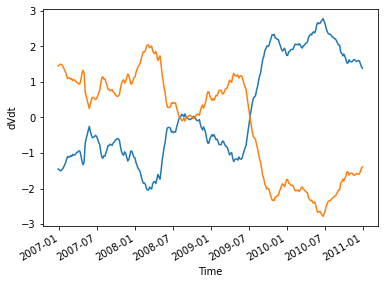

In [58]:
dVdt_anom_bot.plot()
dVdt_anom_deep.plot();

### $\Psi$

In [59]:
psi_anom_deep = anom.psi_vel.sel(sigma2_bin=1037.125, method='nearest') - anom.psi_vel.isel(sigma2_bin=0)
psi_anom_deep.load()

<xarray.DataArray 'psi_vel' (time: 366)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -4.40645833, -4.33945313, -4.34159696,
       -4.30129046, -4.26658656, -4.23861853, -4.20693651, -4.20588505,
       -4.27582933, -4.24540974, -4.20905857, -4.19806981, -4.13191476,
       -4.09445795, -4.02720882, -3.93914731, -3.86544551, -3.81904443,
       -3.74557155, -3.73008053, -3.67736435, -3.69064251, -3.68578593,
       -3.69176933, -3.67770555, -3.65027563, -3.68369823, -3.71593506,
...
        1.3426012 ,  1.28845051,  1.31420445,  1.25194486,  1.27727078,
        1.2836333 ,  1.28770069,  1.33881234,  1.42344344,  1.4470645 ,
        1.44378051,  1.4422179 ,  1.45959081,  1.48007431,  1.45773691,
        1.48112392,  1.53022363,  1.58138944,  1.57371558,  1.52976009,
        1.48971631,  1.45098436,  1.38052268,  1.30077427,  1.2548932 ,
        1.20272923,  1.14119306,  1.15369945,  1.10760201,  1.04953844,
        1.05482034,  1.01669968,  0.97864919,  0.95782866,  0.92823165,
        0.94069857,  0.98396057,  1.01466931,  0.94716573,  0.97822738,
        0.96867543,  0.99755731,  1.04504458,  1.07504237,  1.14024506,
        1.22027806,  1.16352641,  1.14807757,  1.20461905,  1.20609892,
        1.1615948 ,  1.1343558 ,  1.1082004 ,  1.15604845,  1.11258241,
        1.10607315,  1.12613594,  1.06455094,  1.06872709,  1.10643267,
        1.1399624 ,  1.18386791,  1.22296107,  1.26952734,  1.29631211,
        1.31658014,  1.37353616,  1.43315691,  1.55670816,  1.61042705,
        1.68695846,  1.74467214,  1.8736116 ,  1.9556323 ,  2.07164506,
        2.14452674,  2.25053661,  2.23633637,  2.21456688,  2.22037098,
        2.24769166,  2.28762572,  2.40681624,  2.4300007 ,  2.47912821,
        2.51550542,  2.55398142,  2.63099414,  2.71852326,  2.73665564,
        2.73257028,  2.76383521,  2.77377448,  2.82545438,  2.83994148,
        2.85827197])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 1 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

In [60]:
psi_anom_bot = anom.psi_vel.isel(sigma2_bin=-1) - anom.psi_vel.sel(sigma2_bin=1037.125, method='nearest')
psi_anom_bot.load()

<xarray.DataArray 'psi_vel' (time: 366)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
        4.40403985e+00,  4.33013967e+00,  4.32296404e+00,  4.31614350e+00,
        4.27271154e+00,  4.24217827e+00,  4.21015643e+00,  4.21078012e+00,
...
       -1.56556682e+00, -1.51675229e+00, -1.49489513e+00, -1.43644443e+00,
       -1.39177919e+00, -1.29859551e+00, -1.25388791e+00, -1.19360384e+00,
       -1.13501351e+00, -1.13944027e+00, -1.11309821e+00, -1.04768140e+00,
       -1.04790022e+00, -9.97011573e-01, -9.70982274e-01, -9.40892724e-01,
       -9.31413270e-01, -9.42250998e-01, -9.78216729e-01, -9.84841761e-01,
       -9.66251259e-01, -9.85008657e-01, -9.78292103e-01, -1.01178373e+00,
       -1.05154970e+00, -1.06983923e+00, -1.14332307e+00, -1.22074893e+00,
       -1.17218198e+00, -1.14686961e+00, -1.19116617e+00, -1.23279129e+00,
       -1.16857903e+00, -1.13872092e+00, -1.16127661e+00, -1.14711899e+00,
       -1.09921511e+00, -1.12164728e+00, -1.10835852e+00, -1.06611525e+00,
       -1.09064803e+00, -1.11358217e+00, -1.14670766e+00, -1.17249236e+00,
       -1.21028677e+00, -1.27083076e+00, -1.32237432e+00, -1.32151029e+00,
       -1.38361495e+00, -1.45047366e+00, -1.57417245e+00, -1.62079762e+00,
       -1.69970752e+00, -1.75552701e+00, -1.87780568e+00, -1.94177055e+00,
       -2.07647598e+00, -2.15092183e+00, -2.23056585e+00, -2.22900572e+00,
       -2.19083810e+00, -2.24859231e+00, -2.23040760e+00, -2.28673839e+00,
       -2.38795014e+00, -2.42651099e+00, -2.48953241e+00, -2.52054928e+00,
       -2.54046763e+00, -2.64330020e+00, -2.72698873e+00, -2.74961778e+00,
       -2.73482470e+00, -2.76113460e+00, -2.78967251e+00, -2.82515842e+00,
       -2.83564199e+00, -2.85010308e+00])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 1 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

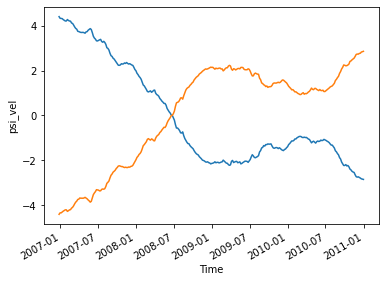

In [61]:
psi_anom_bot.plot()
psi_anom_deep.plot();

### $\Omega$

In [62]:
omega_anom_deep = anom.omega_trans_rate.sel(sigma2_bin=1037.125, method='nearest') - anom.omega_trans_rate.isel(sigma2_bin=0)
omega_anom_deep.load()

<xarray.DataArray 'omega_trans_rate' (time: 366)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  5.84808111,  5.90961692,  5.87090768,
        5.82016354,  5.73447669,  5.64711882,  5.62248644,  5.57868827,
        5.55667077,  5.55055219,  5.56570115,  5.47326668,  5.40876667,
        5.46683707,  5.3548942 ,  5.36505603,  5.2021684 ,  5.24281138,
        5.09012024,  5.09539471,  5.13488556,  4.84861336,  5.00574895,
        5.17413889,  5.03903969,  5.11251611,  5.86195466,  4.41288208,
...
       -4.96121099, -4.38892496, -1.63390943, -3.80969526, -3.39270853,
       -2.65311967, -2.37189453, -4.39121981, -4.91465683, -4.16561083,
       -2.00050948, -1.93067582, -2.36038583, -3.19885473, -1.53336084,
       -2.37216379, -2.42206374, -1.03354222, -1.92696525, -1.99524797,
       -1.97940635, -1.12961019, -1.48820768, -1.50958524, -1.5032873 ,
       -1.50866034, -1.51246717, -1.48939101, -1.4830152 , -1.49097937,
       -1.49963813, -1.50869527, -1.50494779, -1.50451074, -1.50387868,
       -1.49382891, -1.48991726, -1.49340886, -1.5553259 , -1.57183799,
       -1.60951973, -1.70646467, -1.61408298, -1.42984756, -1.46437025,
       -0.95764706, -1.26729716, -1.54475721, -2.26548226, -2.54950383,
       -1.73945081, -2.24105269, -2.88053554, -1.90598827, -2.01972556,
       -2.39115766, -1.70353494, -1.8663339 , -2.71116897, -2.75892386,
       -2.36325324, -1.64564813, -1.72380921, -2.11323892, -2.31381464,
       -2.34790165, -2.43936673, -3.03813909, -3.82997587, -2.30587241,
       -2.12373866, -2.29113844, -2.07494389, -1.6197813 , -1.62399333,
       -1.77478793, -1.38714318, -1.06569599, -0.2978609 , -3.02007656,
       -1.76658126, -1.72437904, -1.61346097, -2.15851697, -3.2050619 ,
       -2.07430594, -2.03768423, -3.08228036, -3.15867153, -3.40892053,
       -3.1143027 , -2.98574347, -3.3912124 , -3.21167809, -3.19181654,
       -3.16674795])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 1 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

In [63]:
omega_anom_bot = anom.omega_trans_rate.isel(sigma2_bin=-1) - anom.omega_trans_rate.sel(sigma2_bin=1037.125, method='nearest')
omega_anom_bot.load()

<xarray.DataArray 'omega_trans_rate' (time: 366)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -5.84808111, -5.90961692, -5.87090768,
       -5.82016354, -5.73447669, -5.64711882, -5.62248644, -5.57868827,
       -5.55667077, -5.55055219, -5.56570115, -5.47326668, -5.40876667,
       -5.46683707, -5.3548942 , -5.36505603, -5.2021684 , -5.24281138,
       -5.09012024, -5.09539471, -5.13488556, -4.84861336, -5.00574895,
       -5.17413889, -5.03903969, -5.11251611, -5.86195466, -4.41288208,
...
        4.96121099,  4.38892496,  1.63390943,  3.80969526,  3.39270853,
        2.65311967,  2.37189453,  4.39121981,  4.91465683,  4.16561083,
        2.00050948,  1.93067582,  2.36038583,  3.19885473,  1.53336084,
        2.37216379,  2.42206374,  1.03354222,  1.92696525,  1.99524797,
        1.97940635,  1.12961019,  1.48820768,  1.50958524,  1.5032873 ,
        1.50866034,  1.51246717,  1.48939101,  1.4830152 ,  1.49097937,
        1.49963813,  1.50869527,  1.50494779,  1.50451074,  1.50387868,
        1.49382891,  1.48991726,  1.49340886,  1.5553259 ,  1.57183799,
        1.60951973,  1.70646467,  1.61408298,  1.42984756,  1.46437025,
        0.95764706,  1.26729716,  1.54475721,  2.26548226,  2.54950383,
        1.73945081,  2.24105269,  2.88053554,  1.90598827,  2.01972556,
        2.39115766,  1.70353494,  1.8663339 ,  2.71116897,  2.75892386,
        2.36325324,  1.64564813,  1.72380921,  2.11323892,  2.31381464,
        2.34790165,  2.43936673,  3.03813909,  3.82997587,  2.30587241,
        2.12373866,  2.29113844,  2.07494389,  1.6197813 ,  1.62399333,
        1.77478793,  1.38714318,  1.06569599,  0.2978609 ,  3.02007656,
        1.76658126,  1.72437904,  1.61346097,  2.15851697,  3.2050619 ,
        2.07430594,  2.03768423,  3.08228036,  3.15867153,  3.40892053,
        3.1143027 ,  2.98574347,  3.3912124 ,  3.21167809,  3.19181654,
        3.16674795])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 1 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

In [63]:
omega_anom = anom.omega_trans_rate.sel(sigma2_bin=1037.125, method='nearest')
omega_anom.load()

<xarray.DataArray 'omega_trans_rate' (time: 366)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -5.84808111, -5.90961692, -5.87090768,
       -5.82016354, -5.73447669, -5.64711882, -5.62248644, -5.57868827,
       -5.55667077, -5.55055219, -5.56570115, -5.47326668, -5.40876667,
       -5.46683707, -5.3548942 , -5.36505603, -5.2021684 , -5.24281138,
       -5.09012024, -5.09539471, -5.13488556, -4.84861336, -5.00574895,
       -5.17413889, -5.03903969, -5.11251611, -5.86195466, -4.41288208,
...
        4.96121099,  4.38892496,  1.63390943,  3.80969526,  3.39270853,
        2.65311967,  2.37189453,  4.39121981,  4.91465683,  4.16561083,
        2.00050948,  1.93067582,  2.36038583,  3.19885473,  1.53336084,
        2.37216379,  2.42206374,  1.03354222,  1.92696525,  1.99524797,
        1.97940635,  1.12961019,  1.48820768,  1.50958524,  1.5032873 ,
        1.50866034,  1.51246717,  1.48939101,  1.4830152 ,  1.49097937,
        1.49963813,  1.50869527,  1.50494779,  1.50451074,  1.50387868,
        1.49382891,  1.48991726,  1.49340886,  1.5553259 ,  1.57183799,
        1.60951973,  1.70646467,  1.61408298,  1.42984756,  1.46437025,
        0.95764706,  1.26729716,  1.54475721,  2.26548226,  2.54950383,
        1.73945081,  2.24105269,  2.88053554,  1.90598827,  2.01972556,
        2.39115766,  1.70353494,  1.8663339 ,  2.71116897,  2.75892386,
        2.36325324,  1.64564813,  1.72380921,  2.11323892,  2.31381464,
        2.34790165,  2.43936673,  3.03813909,  3.82997587,  2.30587241,
        2.12373866,  2.29113844,  2.07494389,  1.6197813 ,  1.62399333,
        1.77478793,  1.38714318,  1.06569599,  0.2978609 ,  3.02007656,
        1.76658126,  1.72437904,  1.61346097,  2.15851697,  3.2050619 ,
        2.07430594,  2.03768423,  3.08228036,  3.15867153,  3.40892053,
        3.1143027 ,  2.98574347,  3.3912124 ,  3.21167809,  3.19181654,
        3.16674795])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 1 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

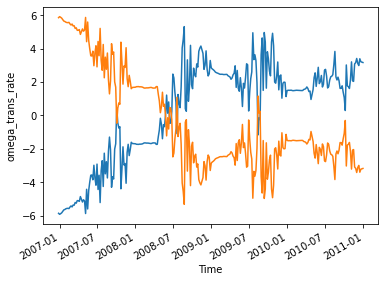

In [64]:
omega_anom_bot.plot()
omega_anom_deep.plot();

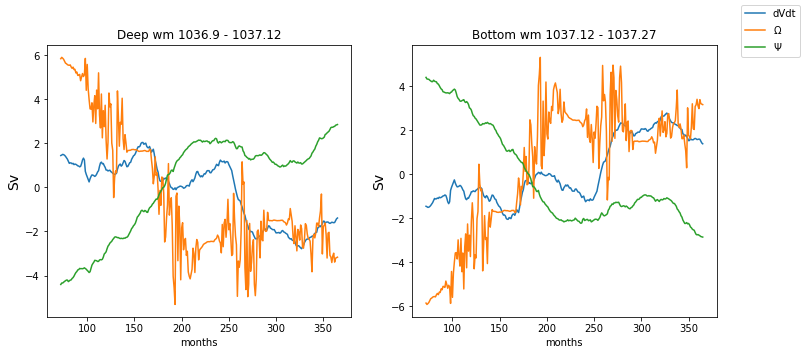

In [65]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.plot(dVdt_anom_deep, label='dVdt')
ax0.plot(omega_anom_deep, label=r'$\Omega$')
ax0.plot(psi_anom_deep, label=r'$\Psi$')

ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('months')

ax1.plot(dVdt_anom_bot)#, label='dVdt')
ax1.plot(omega_anom_bot)#, label=r'$\Omega$')
ax1.plot(psi_anom_bot)#, label=r'$\Psi$')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('months')

fig.legend();

## Indices

In [94]:
indices

<xarray.Dataset>
Dimensions:          (time: 60)
Coordinates:
  * time             (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2010-12-01
Data variables:
    enso             (time) float32 -0.7034 -0.6278 -0.392 ... -1.47 -1.44
    fw_flx           (time) float32 0.06174 0.3266 -0.6006 ... -0.1008 0.9542
    heat_flx         (time) float32 0.9099 0.5741 0.6695 ... 0.2288 -0.04812
    sam              (time) float64 0.1723 -1.534 1.666 ... 3.167 3.901 0.09625
    sose             (time) float32 -0.1024 -0.3163 -0.7164 ... -0.4328 -0.4636
    windstress_curl  (time) float32 0.1545 0.4456 0.4518 ... -2.025 -0.3768

In [112]:
deep

<xarray.Dataset>
Dimensions:           (time: 366)
Coordinates:
  * time              (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
Data variables:
    R1                (time) float64 nan nan nan nan ... -0.9546 -1.244 -1.39
    R2                (time) float64 nan nan nan nan ... -0.2517 -0.316 -0.2989
    dVdt              (time) float64 nan nan nan nan ... -1.206 -1.268 -1.269
    omega_mix         (time) float64 nan nan nan nan ... -2.17 -2.288 -2.185
    omega_surf_slt    (time) float64 nan nan nan nan ... -1.7 -1.757 -1.786
    omega_surf_th     (time) float64 nan nan nan nan ... -0.3095 -0.2313 -0.1964
    omega_trans_rate  (time) float64 nan nan nan nan ... -1.444 -1.438 -1.455
    psi_vel           (time) float64 nan nan nan nan ... 2.301 2.378 2.42 2.432

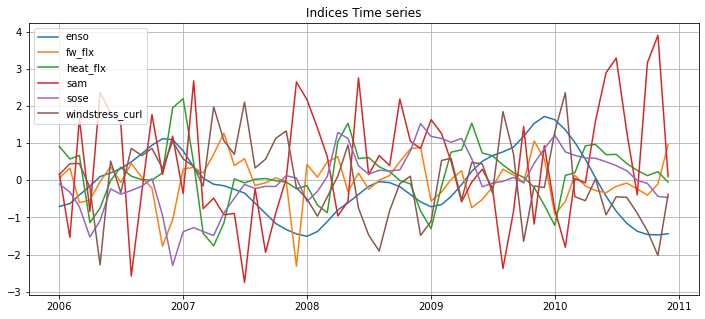

In [111]:
fig, ax = plt.subplots(figsize=(12,5))
for i in indices.variables:
    if i =='time':
        continue
    ax.plot(indices.time, indices[i], label=f'{indices[i].name}')
    
plt.legend()
plt.grid()
plt.title('Indices Time series');

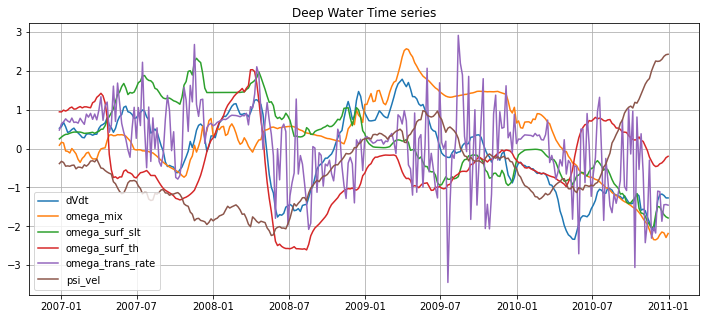

In [119]:
fig, ax = plt.subplots(figsize=(12,5))
for i in deep.variables:
    if i =='time':
        continue
    if i=='R1':
        continue
    if i=='R2':
        continue
    ax.plot(deep.time, deep[i], label=f'{deep[i].name}')
    
plt.legend()
plt.grid()
plt.title('Deep Water Time series');

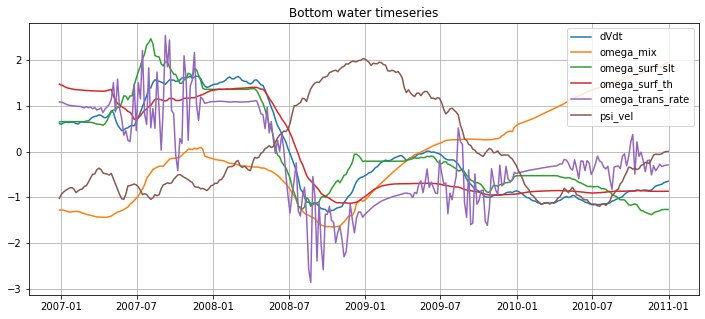

In [118]:
fig, ax = plt.subplots(figsize=(12,5))
for i in bottom.variables:
    if i =='time':
        continue
    if i=='R1':
        continue
    if i=='R2':
        continue
    ax.plot(bottom.time, bottom[i], label=f'{bottom[i].name}')
    
plt.legend()
plt.grid()
plt.title('Bottom water timeseries');

## Heat map of Corralation matrices

In [134]:
import seaborn as sn

In [122]:
indices_df = indices.to_dataframe()
indices_df.head()

,enso,fw_flx,heat_flx,sam,sose,windstress_curl
time,,,,,,
2006-01-01,-0.703412,0.061736,0.909883,0.172308,-0.102403,0.154478
2006-02-01,-0.627783,0.326616,0.574079,-1.533846,-0.316302,0.445615
2006-03-01,-0.392023,-0.600639,0.669474,1.665538,-0.716384,0.451785
2006-04-01,-0.160018,-0.538129,-1.137979,-0.839846,-1.526455,-0.196582
2006-05-01,0.099242,-0.036327,-0.748289,2.373692,-1.089656,-2.279050


### Deep Water Corr Matrix

In [126]:
deep.resample(time='MS').mean()

<xarray.Dataset>
Dimensions:           (time: 60)
Coordinates:
  * time              (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2010-12-01
Data variables:
    R1                (time) float64 nan nan nan nan ... -1.046 -1.65 -1.368
    R2                (time) float64 nan nan nan nan ... -1.124 -0.1339 -0.1639
    dVdt              (time) float64 nan nan nan nan ... -1.347 -1.826 -1.321
    omega_mix         (time) float64 nan nan nan nan ... -1.575 -2.048 -2.238
    omega_surf_slt    (time) float64 nan nan nan nan ... -1.39 -1.88 -1.65
    omega_surf_th     (time) float64 nan nan nan nan ... 0.2499 -0.1241 -0.3431
    omega_trans_rate  (time) float64 nan nan nan nan ... -0.2611 -1.599 -1.511
    psi_vel           (time) float64 nan nan nan nan ... 0.808 1.197 1.814 2.327

In [129]:
deep_df = deep.resample(time='MS').mean().to_dataframe()
deep_df.head()

,R1,R2,dVdt,omega_mix,omega_surf_slt,omega_surf_th,omega_trans_rate,psi_vel
time,,,,,,,,
2006-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
deep_ind = pd.concat([deep_df, indices_df], axis=1)
deep_ind.tail()

,R1,R2,dVdt,omega_mix,omega_surf_slt,omega_surf_th,omega_trans_rate,psi_vel,enso,fw_flx,heat_flx,sam,sose,windstress_curl
time,,,,,,,,,,,,,,
2010-08-01,-0.732610,0.669280,-1.101533,-1.100016,-0.727832,0.666261,-1.121124,-0.003222,-1.156375,-0.074501,0.452923,1.304531,0.256971,-0.459329
2010-09-01,-0.820570,-0.743931,-1.273671,-1.336341,-1.227721,0.438083,-0.374826,0.807966,-1.372571,-0.232771,0.265406,-0.392656,-0.005690,-0.887641
2010-10-01,-1.045891,-1.123883,-1.346818,-1.574599,-1.390394,0.249915,-0.261085,1.197432,-1.459237,-0.402171,0.126579,3.167031,-0.085412,-1.363300
2010-11-01,-1.649880,-0.133936,-1.825993,-2.048247,-1.880278,-0.124135,-1.599207,1.813592,-1.470133,-0.100824,0.228844,3.901406,-0.432815,-2.025066
2010-12-01,-1.368065,-0.163927,-1.320854,-2.237861,-1.650450,-0.343129,-1.511382,2.327367,-1.439778,0.954187,-0.048120,0.096250,-0.463637,-0.376755


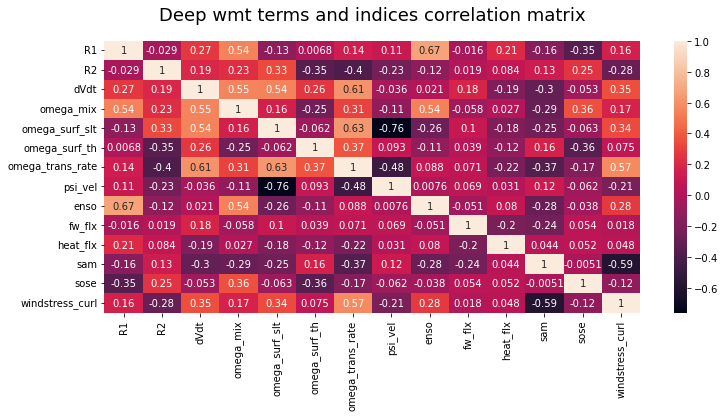

In [143]:
plt.figure(figsize=(12,5))
sn.heatmap(deep_ind.corr(), annot=True)
plt.title('Deep wmt terms and indices correlation matrix', fontsize=18, pad=20.5);

### Bottom Waterr Corr Matrix

In [144]:
bottom_df = bottom.resample(time='MS').mean().to_dataframe()
bottom_df.head()

,R1,R2,dVdt,omega_mix,omega_surf_slt,omega_surf_th,omega_trans_rate,psi_vel
time,,,,,,,,
2006-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
bottom_ind = pd.concat([bottom_df, indices_df], axis=1)
bottom_ind.tail()

,R1,R2,dVdt,omega_mix,omega_surf_slt,omega_surf_th,omega_trans_rate,psi_vel,enso,fw_flx,heat_flx,sam,sose,windstress_curl
time,,,,,,,,,,,,,,
2010-08-01,1.137889,-0.206450,-1.101051,1.493661,-0.909198,-0.877245,-0.468518,-1.019885,-1.156375,-0.074501,0.452923,1.304531,0.256971,-0.459329
2010-09-01,1.177008,-0.826916,-0.955202,1.582155,-1.076844,-0.866691,-0.212309,-0.588181,-1.372571,-0.232771,0.265406,-0.392656,-0.005690,-0.887641
2010-10-01,1.214533,-1.365893,-0.858221,1.675813,-1.196864,-0.858611,0.028833,-0.362851,-1.459237,-0.402171,0.126579,3.167031,-0.085412,-1.363300
2010-11-01,1.244309,-0.734295,-0.838756,1.758919,-1.344753,-0.864762,-0.310078,-0.213766,-1.470133,-0.100824,0.228844,3.901406,-0.432815,-2.025066
2010-12-01,1.273887,-0.576407,-0.705304,1.878033,-1.285423,-0.870608,-0.326588,-0.035743,-1.439778,0.954187,-0.048120,0.096250,-0.463637,-0.376755


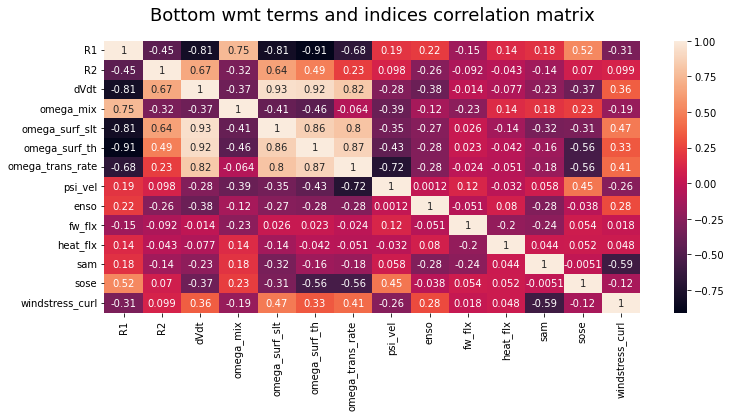

In [146]:
plt.figure(figsize=(12,5))
sn.heatmap(bottom_ind.corr(), annot=True)
plt.title('Bottom wmt terms and indices correlation matrix', fontsize=18, pad=20.5);

### Correlation matrix of all terms (deep, bottom, indices)

In [153]:
corr_matrix = pd.concat([deep_df, bottom_df, indices_df], axis=1)
#corr_matrix = pd.concat([deep_ind, bottom_df], axis=1)
corr_matrix.head()

,R1,R2,dVdt,omega_mix,omega_surf_slt,omega_surf_th,omega_trans_rate,psi_vel,R1,R2,...,omega_surf_slt,omega_surf_th,omega_trans_rate,psi_vel,enso,fw_flx,heat_flx,sam,sose,windstress_curl
time,,,,,,,,,,,,,,,,,,,,,
2006-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.703412,0.061736,0.909883,0.172308,-0.102403,0.154478
2006-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.627783,0.326616,0.574079,-1.533846,-0.316302,0.445615
2006-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.392023,-0.600639,0.669474,1.665538,-0.716384,0.451785
2006-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.160018,-0.538129,-1.137979,-0.839846,-1.526455,-0.196582
2006-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.099242,-0.036327,-0.748289,2.373692,-1.089656,-2.279050


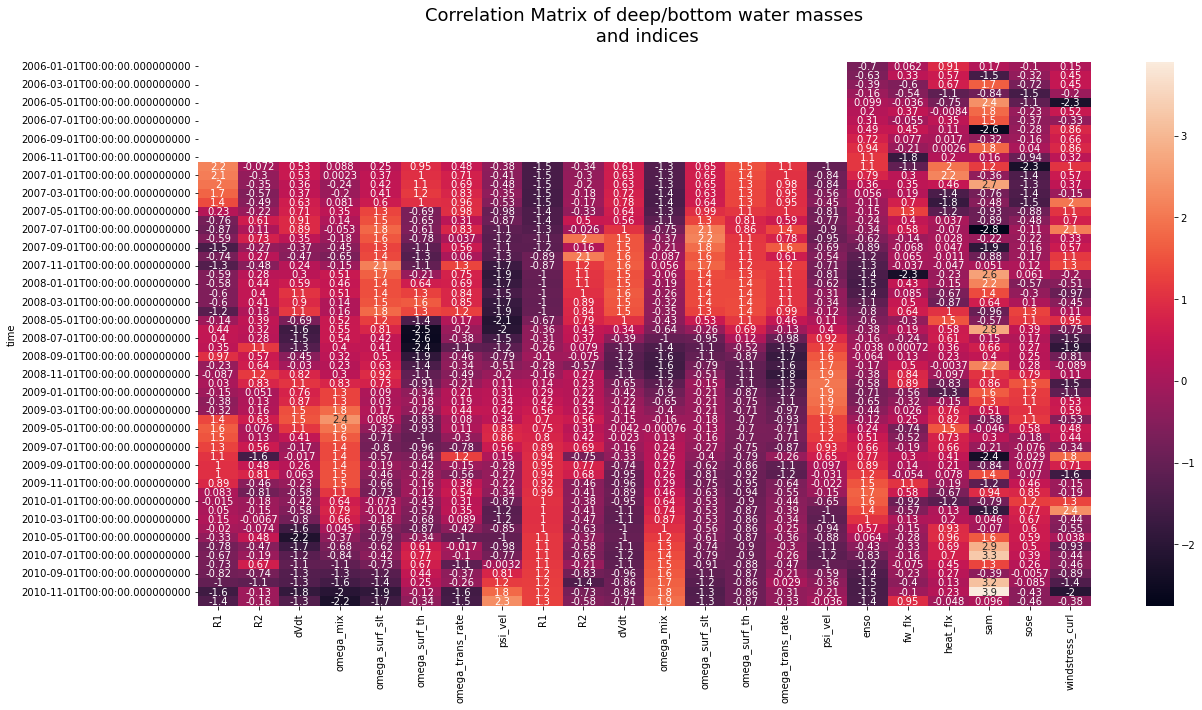

In [154]:
plt.figure(figsize=(20,10))
sn.heatmap(corr_matrix, annot=True)
plt.title('Correlation Matrix of deep/bottom water masses\n and indices', fontsize=18, pad=20.5);